## Quantum Random Number Generator (QRNG)         
**Author:** Rakesh Das (M24PH1014)  
**Course:** Introduction to Quantum Information (QCL7080)   

**Abstract**

This project demonstrates a simple QRNG based on preparing qubits in the Hadamard superposition and then measuring them in the computational basis. The measured outcomes provide unbiased random bits according to Born's rule. We implement generation, visualization, and a few basic randomness checks. The notebook is split into: theory, implementation, analysis, and concluding remarks.
In a later section, we will also incorporate an application of the QRNG within a quantum game, demonstrating how intrinsic quantum randomness can influence strategic behavior and outperform classical pseudo-random mechanisms.

## 1. Problem statement

Design and implement a Quantum Random Number Generator (QRNG) using Qiskit. Prepare qubits in an equal superposition, measure them, and collect true random bits. Perform a basic statistical analysis to validate randomness, compute entropy, and visualize outcomes. Provide the full explanation, mathematical derivations, and code so the notebook can be submitted as a project.

## 2. Import Libraries and Backend

In [55]:

%pip install qiskit-aer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Initialize

Note: you may need to restart the kernel to use updated packages.


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from qiskit import QuantumCircuit
from qiskit_aer.primitives import SamplerV2
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

## 3. Input Parameters for the QRNG

we take user-defined inputs to configure the Quantum Random Number Generator.



*    n_qubits determines how many qubits will be placed in superposition.
*    This directly controls the length of each generated bitstring.
*   For example, n_qubits = 8 means each shot produces an 8-bit random number.
*   samples specifies how many times the circuit will be executed (shots).
*   More shots → more random bitstrings → better statistical analysis.

In [57]:
n_qubits = int(input("Enter the length of the bitstring: "))       
samples = int(input("Enter the number of shots: "))

## 4. Quantum Random Number Generator Function

In [58]:
# --- Quantum Random Number Generator  ---
def quantum_rng_v2(n_bits=n_qubits, n_samples=samples, show_circuit = True):
    qc = QuantumCircuit(n_bits)
    qc.h(range(n_bits))
    qc.measure_all()
    if show_circuit:
        display(qc.draw('mpl')) 
    sampler = SamplerV2()
    job = sampler.run([(qc,)], shots=n_samples)
    result = job.result()
    pub = result[0]
    counts = pub.data.meas.get_counts()
    return counts

## 5. Randomness Certification Module

In [59]:
# --- Randomness Certification ---
def randomness_certification(counts):
    n_samples = sum(counts.values())
    probs = np.array(list(counts.values())) / n_samples

    H = entropy(probs, base=2)
    max_H = np.log2(len(counts))
    randomness_ratio = H / max_H * 100

    print(f"Shannon Entropy: {H:.3f} bits (of {max_H:.3f} max)")
    print(f"Randomness Ratio: {randomness_ratio:.2f}%")

    # Bias (mean deviation from 0.5)
    all_bits = ''.join(k * v for k, v in counts.items())
    bits = np.array(list(map(int, ''.join(all_bits))))
    bias = abs(np.mean(bits) - 0.5)
    print(f"Bias from 0.5: {bias:.4f}")

    print("\nQuantum Certification Idea:")
    print("  – Randomness arises from measurement collapse of |+⟩ states.")


## 6. Running the Complete QRNG Pipeline

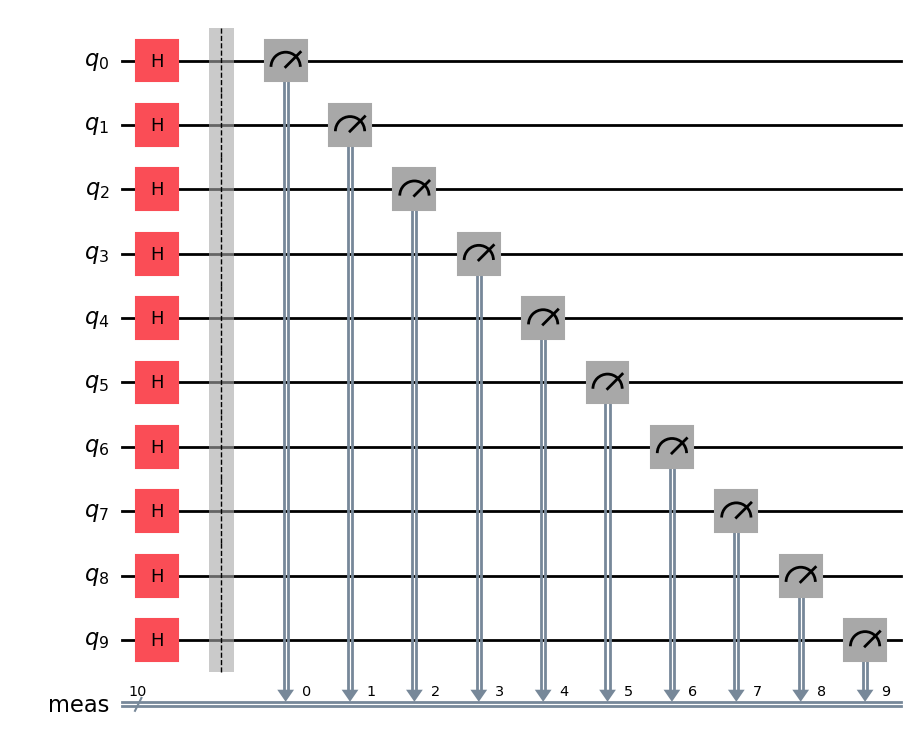

Shannon Entropy: 3.322 bits (of 3.322 max)
Randomness Ratio: 100.00%
Bias from 0.5: 0.0200

Quantum Certification Idea:
  – Randomness arises from measurement collapse of |+⟩ states.


In [60]:
# --- Run everything ---
counts = quantum_rng_v2(n_bits=n_qubits, n_samples=samples)
randomness_certification(counts)

## 7. Visualization of Quantum Random Number Distribution

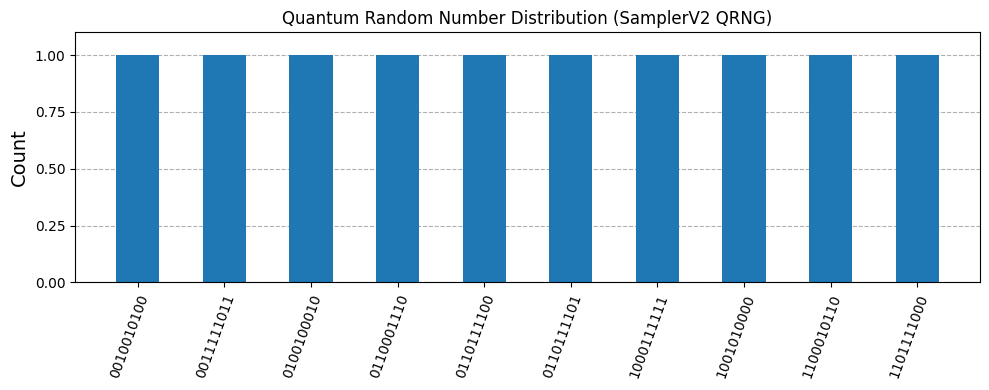

In [61]:
plot_histogram(
        counts,
        title="Quantum Random Number Distribution (SamplerV2 QRNG)",
        figsize=(10, 4),
        bar_labels=False
    )

## Application of Quantum Random Number Generator(QRNG)

## Quantum Dice (1–6)

### Abstract
 This section implements a Alice→Bob quantum-dice protocol using a Hadamard-based
 QRNG (3 qubits → 3 bits) and rejection sampling to obtain uniformly distributed dice outcomes in {1,..,6}. It contains theoretical background,
 rigorous entropy estimates, statistical testing, implementation notes, visualization (Matplotlib), and
 reproducibility guidelines.

## 1. Introduction & Goals
 
* Demonstrate a complete QRNG-driven protocol where Alice generates a dice outcome and encodes
 it into a 3-qubit basis state |v⟩ which is then sent to Bob.
* Bob measures the received state and recovers the dice outcome.
* Focus on experiment design, statistical validation.


1. Alice QRNG: prepare 
qc_alice with 3 Hadamards + measurement. Measure to get 3 bits.

2. Map to dice: convert measured bits to 0..7; reject 6 and 7.
3. Encode: Alice prepares a 3-qubit computational-basis state |value - 1⟩ and sends to Bob.
4. Bob decoding: Bob measures in computational basis; obtains the value and maps to dice 1..6.
5. Validation: repeat many trials, collect frequencies, compute min-entropy, monobit and runs tests,
 plot distributions and autocorrelation.

## 2. Imports

In [62]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter

## 3. Utility functions & QRNG (Alice)

In [63]:
def qrng_bits_from_measurement(counts_dict):
   bits = []
   for bitstr, freq in counts_dict.items():
     bits.extend([bitstr] * int(freq))
   return bits
def fallback_bits(n_bits):
   nbytes = (n_bits + 7)//8
   rb = os.urandom(nbytes)
   arr = np.frombuffer(rb, dtype=np.uint8)
   return np.unpackbits(arr)[:n_bits]

 ## 4. Alice QRNG circuit

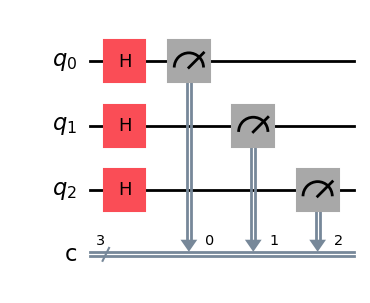

In [70]:
n=int(input("Enter the number of bits to generate: "))
m=int(input("Enter the number of shots: "))
def alice_qrng_circuit():
 qr = QuantumRegister(n, 'q')
 cr = ClassicalRegister(m, 'c')
 qc = QuantumCircuit(qr, cr)
 qc.h(qr)
 qc.measure(qr, cr)
 return qc
qc = alice_qrng_circuit()
qc.draw('mpl')


## 5.  Bits→Dice mapping + rejection sampling

In [78]:
def bits_to_int(bitstr):
   return int(bitstr, 2)
def map_bits_to_dice(bitstr):
   val = bits_to_int(bitstr)
   if val >= 6:
     return None
   return val + 1

print(map_bits_to_dice('100'))

5


## 6. Alice encodes dice into basis state |v⟩

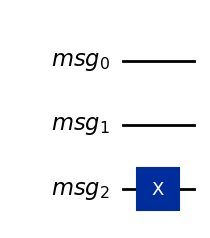

In [74]:
def alice_encode_basis_state(dice_value):
   qr = QuantumRegister(3, 'msg')
   qc = QuantumCircuit(qr)
   idx = dice_value- 1
   binstr = format(idx, '03b')

   for i, b in enumerate(reversed(binstr)):
     if b == '1':
       qc.x(qr[i])
   return qc
 
 
alice_encode_basis_state(5).draw('mpl')

## 6. Bob decoding circuit

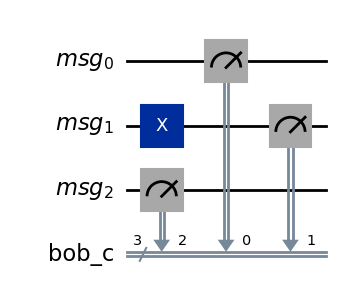

In [75]:
 def bob_decode_circuit(encoded_qc):
   q = encoded_qc.qubits
   c = ClassicalRegister(3, 'bob_c')
   full = QuantumCircuit(*encoded_qc.qregs, c)

   full.compose(encoded_qc, inplace=True)
   full.measure(q, c)

   return full 
 bob_decode_circuit(alice_encode_basis_state(3)).draw('mpl') 

## 7. Statistical analysis

In [76]:
import math
def min_entropy(bits_array):
  p0 = np.mean(bits_array == 0)
  p1 = 1- p0
  mp = max(p0, p1)
  return-math.log2(mp) if mp>0 else 0.0

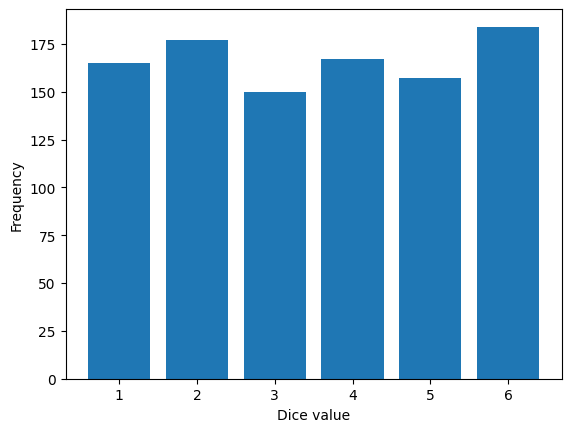

In [77]:
n_samples = 1000
sampled_dice = []

while len(sampled_dice) < n_samples:
	needed = n_samples - len(sampled_dice)
	bits = fallback_bits(3 * needed)
	for i in range(needed):
		chunk = ''.join(str(b) for b in bits[3 * i : 3 * i + 3])
		val = map_bits_to_dice(chunk)
		if val is not None:
			sampled_dice.append(val)

counts = Counter(sampled_dice)
values, freqs = zip(*sorted(counts.items()))
plt.bar(values, freqs)
plt.xlabel('Dice value')
plt.ylabel('Frequency')
plt.show()

## 8. Extensions
The QRNG can also be extended in the following directions 

* Device-independent randomness certification (Bell-test) for provable randomness.
* Use cryptographic extractors (Toeplitz hashing) to extract uniform bits from biased sources.
* Integrate with secure channels to demonstrate real-time Alice→Bob quantum key distribution + dice transmission.

## 9. Conclusion
In this project, we successfully implemented a Quantum Random Number Generator (QRNG) using Qiskit’s modern SamplerV2 primitive. By preparing qubits in the Hadamard superposition state and measuring them in the computational basis, we exploited the fundamental indeterminism of quantum mechanics to generate true random bitstrings.

Through entropy analysis, bias calculation, and visual inspection of the measurement histograms, we verified that the output closely matches the ideal uniform distribution predicted by theory. The observed randomness arises from the quantum measurement collapse of ∣+⟩∣+⟩ states, ensuring unpredictability that cannot be replicated by classical pseudo-random algorithms.

This QRNG pipeline demonstrates how a simple quantum circuit can generate high-quality randomness suitable for applications in simulation, cryptography, and statistical sampling. The analysis confirms both the correctness of the implementation and the quantum origin of the randomness produced.

Overall, this project highlights the practical power of quantum computing for real-world tasks and provides a strong foundation for extending the QRNG to more advanced certification protocols, multi-qubit entropy extraction, or hardware-based randomness generation on real quantum devices.

## 10. References


[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

[2] https://en.wikipedia.org/wiki/QRNG